<a href="https://colab.research.google.com/github/edebolt85/PythonFinalProject/blob/main/FinalProject_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


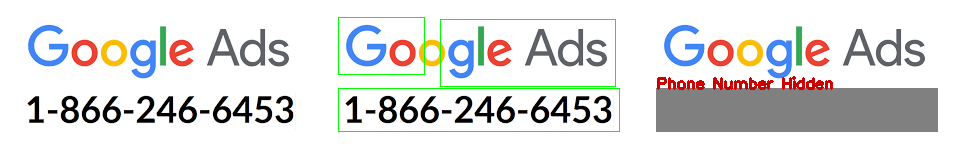

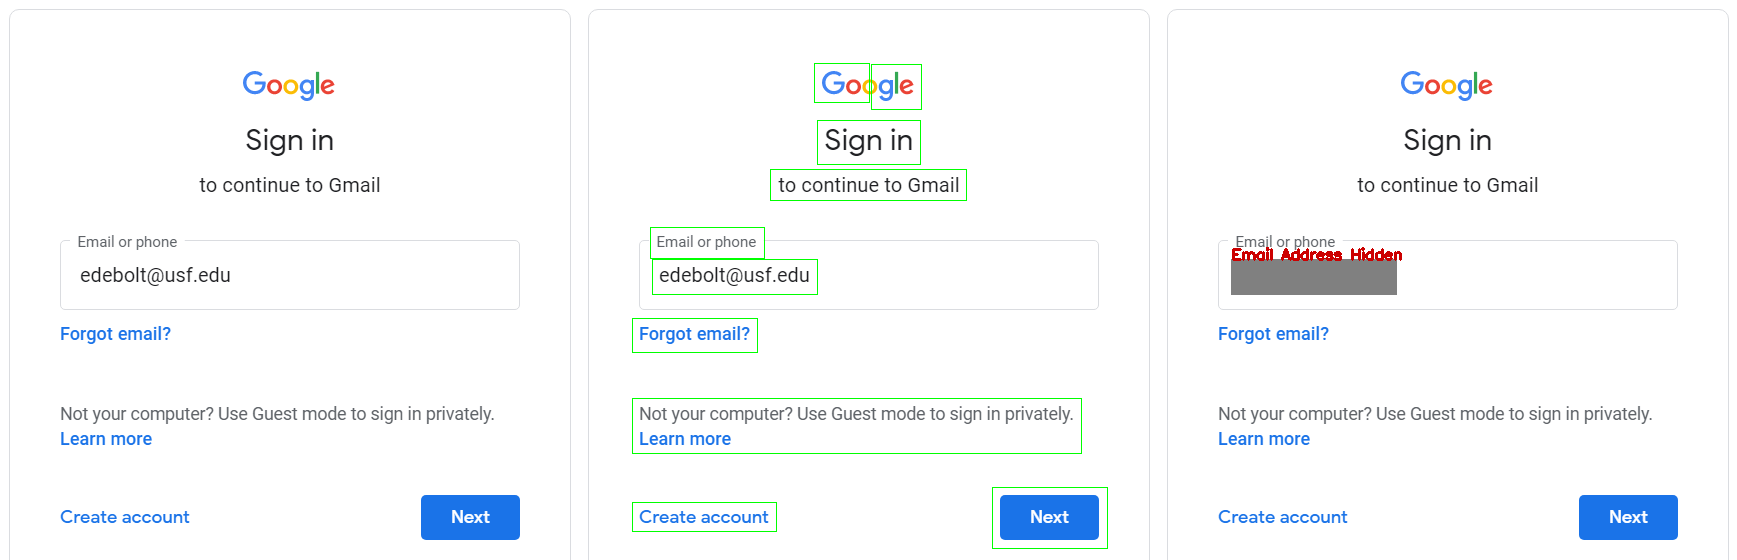

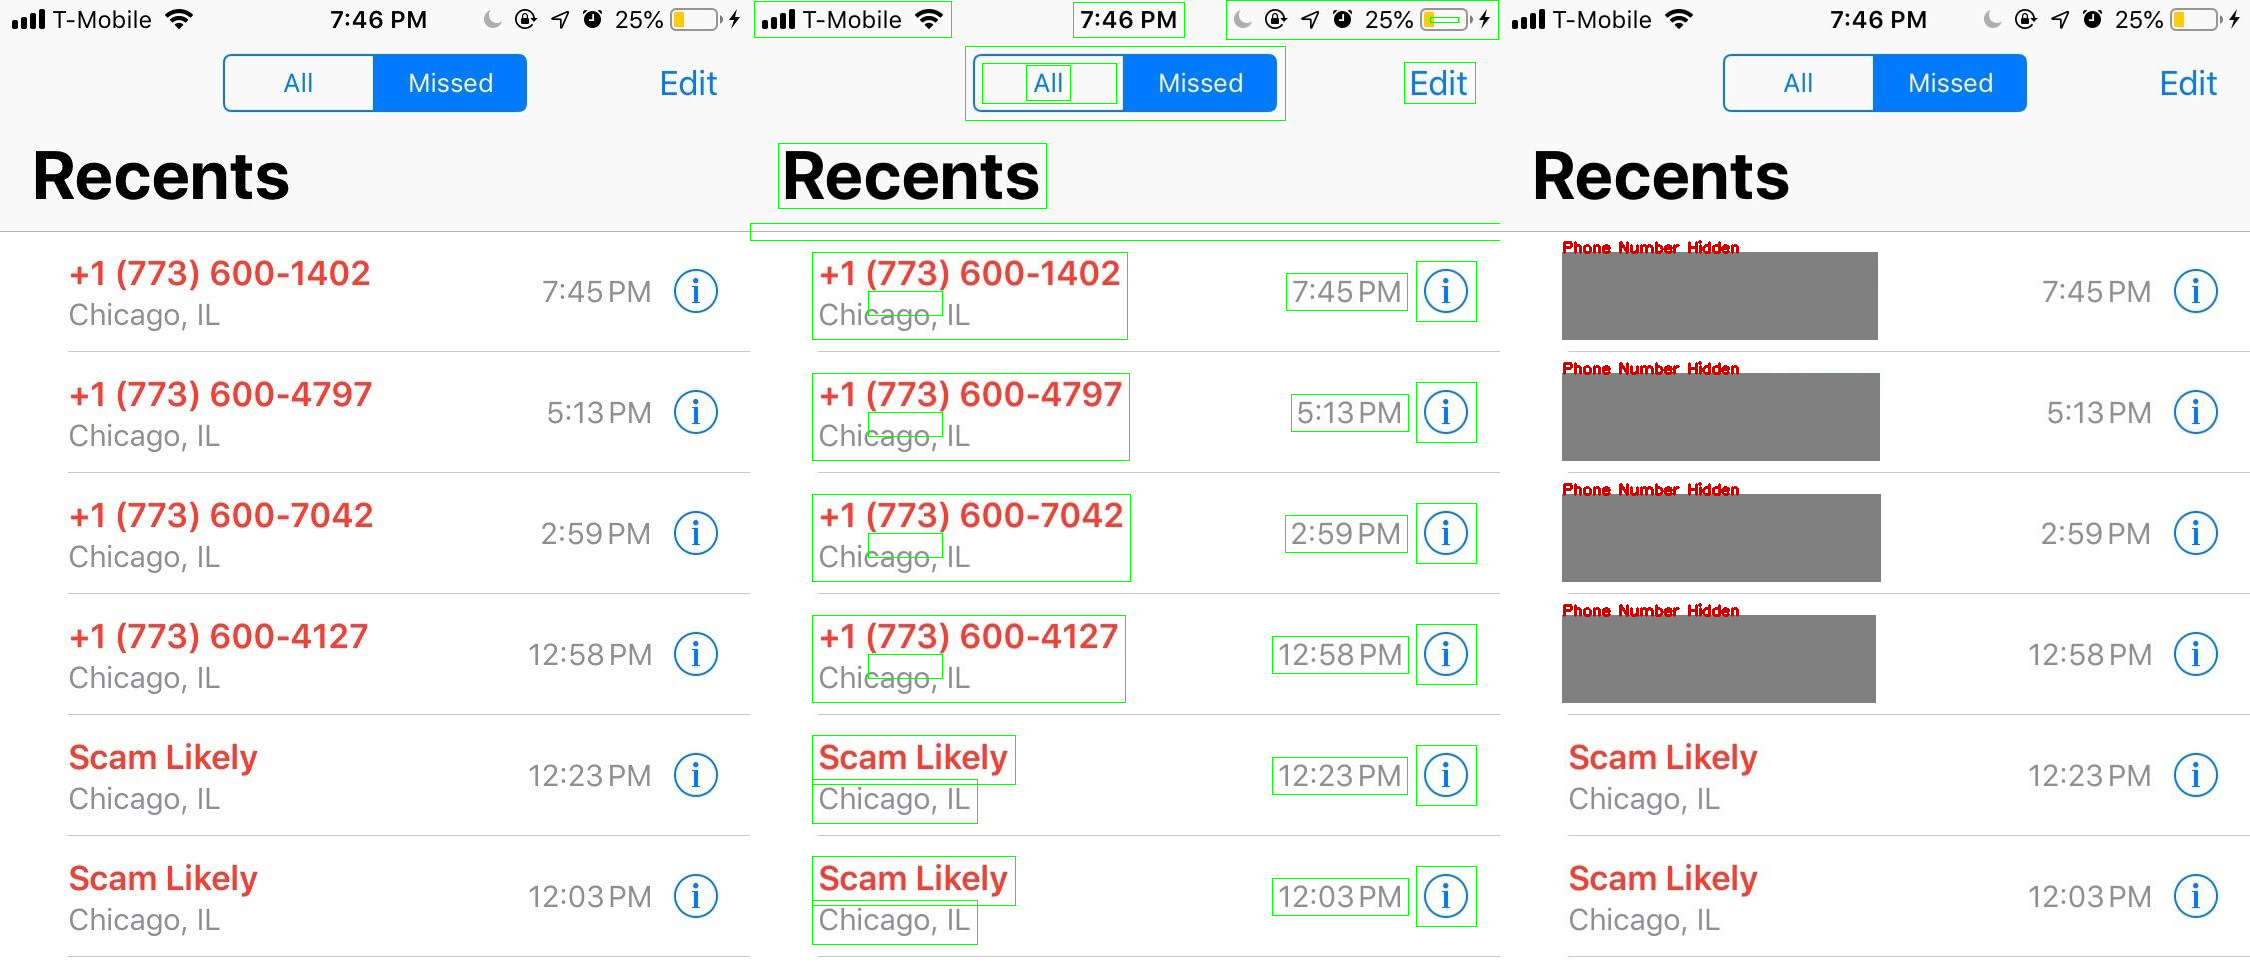

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

import pytesseract
import PIL
import pandas
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import regex as re
import glob
import matplotlib.pyplot as plt


#Create a new directory and set it as the place to look for images we want to analyze
!mkdir /images
image_dir = "/images"

#Create a list of all the image paths that are found in our image directory
images = glob.glob(image_dir + '/*.*')

#This function will use Regex to search for specific criteria and mask the text if found
def searchText(data,x,y,w,h):
  
  #Search for phone numbers
  if re.search(r"(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})", data):
    cv2.rectangle(image,(x,y),(x+w,y+h),(128,128,128),-1)
    cv2.putText(image, "Phone Number Hidden", (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,204), 2)

  #Search for email addresses
  if re.search(r"^(\w|\.|\_|\-)+[@](\w|\_|\-|\.)+[.]\w{2,3}", data):
    cv2.rectangle(image,(x,y),(x+w,y+h),(128,128,128),-1)
    cv2.putText(image, "Email Address Hidden", (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,204), 2)


#Loop through all the individual images and perform multiple functions
for file in images:

  #For every image we are going to store 3 copies so that each copy can be recalled for a specific use.
  #The 'image' copy will be the primary version that we will be working with
  original = cv2.imread(file)
  image = cv2.imread(file)
  image2 = cv2.imread(file)

  #Convert the 'image' file to grayscale, for improved processing
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Apply thresholding to the image in order to highlight pixels that meet criteria
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  #Process the image to accentuate features/objects and to find the contours/edges of the features
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  inverted_thresh = 255 - thresh
  dilate = cv2.dilate(inverted_thresh, kernel, iterations=4)
  cnts = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  #Use PyTesseract's 'image to data' function to extract the text found and store it in a dataframe
  text = pytesseract.image_to_data(image, output_type='data.frame')
 
  #Remove any objects where the confidence is -1
  text = text[text.conf != -1]

  #Group features (i.e. text) that have the same block number (located near each other)
  lines = text.groupby('block_num')['text'].apply(list)
  conf = text.groupby(['block_num'])['conf'].mean()
  
  #Set the contours from the output of the findContours function
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  #Loop through contour coordinates

  for c in cnts:
    x,y, w, h = cv2.boundingRect(c)

    #Filter selection of image based on contour coordinates
    ROI = thresh[y:y + h, x:x + w]

    #Extract text from selected area of image
    data = pytesseract.image_to_string(ROI, lang='eng', config='--psm 6').lower()
    
    #Place a rectangle around the coordinates and save the output as 'image2'
    cv2.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 0)

    #Call the searchText function to determine if the current data value contains information we wish to hide
    searchText(data,x,y,w,h)


    #For each image analyzed create a 3 image output
    #Original image, image with text identified, and then the image with data masked
  list_img = [original, image2, image]
  imgs_comb = np.hstack(list_img)
  cv2_imshow(imgs_comb)

